# 历史旱涝数据说明



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
import os
from hydra import compose, initialize
from shifting_baseline.utils.log import get_logger, adjust_log_level

with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config.yaml")
os.chdir(cfg.ds.root)

# 在 notebook 中动态调整日志等级
log = get_logger()
adjust_log_level(console_level="INFO", file_level="DEBUG")

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

from shifting_baseline.data import HistoricalRecords
from mksci_font import config_font

# 设置seaborn风格
sns.set_style("ticks")
sns.set_context("paper")
config_font({"font.size": 9})

# The commented out code is creating an instance of the `HistoricalRecords` class from the `shifting_baseline.api.series` module. It is passing the `shp_path` and `data_path` parameters to the constructor of `HistoricalRecords` class using values from `cfg.ds.atlas.shp` and `cfg.ds.atlas.file` respectively.
history = HistoricalRecords(
    shp_path=cfg.ds.atlas.shp,
    data_path=cfg.ds.atlas.file,
    symmetrical_level=True,
    to_std=cfg.to_std,
)

INFO | 处理为对称等级 ...
INFO | 处理为标准化等级 ...
INFO | 通过随机采样处理为标准化等级，生成 100 个样本 ...


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:218: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


# 对比重建数据和历史数据

- 历史数据来自《中国千年旱涝图集》
- 重建数据来自 NOAA 的树轮重建数据


Millennial-scale data reveals collective memory of extreme events The impact of extreme weather events such as droughts and floods is intensifying, one important reason being that society quickly forgets past disasters and develops in disaster-prone areas. This collective memory of disasters has significantly affected a society's vulnerability to them. Still, there has long been a lack of data-driven measurements on how long this collective memory lasts. For the first time, we compared historical records with natural reconstructions over a millennium scale in China's Yellow River Basin, demonstrating that the collective memory of extreme climate lasts about 30 years (two generations). The current Earth System Models (ESMs), however, can not have sufficient spatial and temporal resolution to match this pattern, failing to capture the interactions between humans and extreme events. This finding emphasised the necessity of coupling environmental changes with human social systems and improving ESMs for the deep root of the Anthropocene.

## NOAA 树轮重建数据

In [4]:
from shifting_baseline.filters import classify

combined = pd.read_csv(cfg.ds.out.tree_ring, index_col=0)
combined.head()

# tree_ring = classify(tree_ring, handle_na="skip")
tree_ring = combined["mean"]
tree_ring.name = "tree_ring"

,mean,sd,hdi_3%,hdi_97%
year,,,,
1000,-0.154,0.375,-0.868,0.543
1001,-0.060,0.371,-0.732,0.657
1002,0.495,0.455,-0.357,1.368
1003,0.064,0.545,-0.986,1.072
1004,-0.719,0.516,-1.660,0.281


这里我们还可以用一张综合图来说明情况。

由于一般需要5个样本，计算标准差才有意义，所以我们的 `min_periods` 参数比 `windows` 至少要小 5。













INFO | 处理为对称等级 ...
INFO | 处理为标准化等级 ...
INFO | 通过随机采样处理为标准化等级，生成 100 个样本 ...
INFO | 开始计算历史数据和重建数据的相关性
INFO | cfg.agg_method=mean; cfg.to_int=True.
INFO | 开始计算相关性 kendall，时间切片: slice(1469, 1900, None)
INFO | 基准相关系数: 0.18500


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:218: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


INFO | 最大相关性系数: 0.19813，改进百分比: 7.10%
INFO | 最大相关性系数年份: 16.0


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/compare.py:226: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  log.info("最大相关性系数年份: %s", float(filtered_df.idxmax().max()))


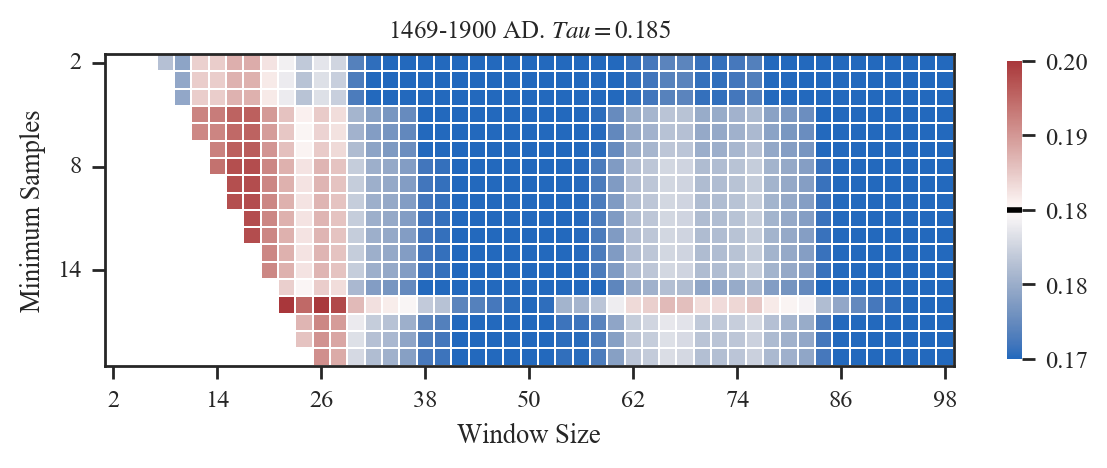

In [5]:
from shifting_baseline.compare import experiment_corr_2d
from shifting_baseline.constants import STAGE1, STAGE2, END
from shifting_baseline.filters import calc_std_deviation

history.setup()
# 实验参数
slice_now = slice(STAGE1, END)

log.info("开始计算历史数据和重建数据的相关性")
log.info(f"cfg.agg_method={cfg.agg_method}; cfg.to_int={cfg.to_int}.")
data1, data2 = history.aggregate(
    cfg.agg_method,
    inplace=True,
    to_int=cfg.to_int,
).merge_with(
    tree_ring,
    time_range=slice_now,
    split=True,
)

fig, ax = plt.subplots(1, 1, figsize=(6, 2.5), tight_layout=True)
df, r_benchmark, ax = experiment_corr_2d(
    data1=data1,
    data2=data2,
    time_slice=slice_now,
    corr_method=cfg.corr_method,
    filter_func=calc_std_deviation,
    filter_side=cfg.filter_side,
    ax=ax,
    n_diff_w=5,
    std_offset=0.1,
)
ax.set_title(
    f"{slice_now.start}-{slice_now.stop} AD. $Tau={r_benchmark:.3f}$",
    fontsize=9,
)
ax.locator_params(axis="x", nbins=9)  # x轴最多9个主刻度
ax.locator_params(axis="y", nbins=4)  # y轴最多9个主刻度
ax.tick_params(axis="both", rotation=0)
plt.show();

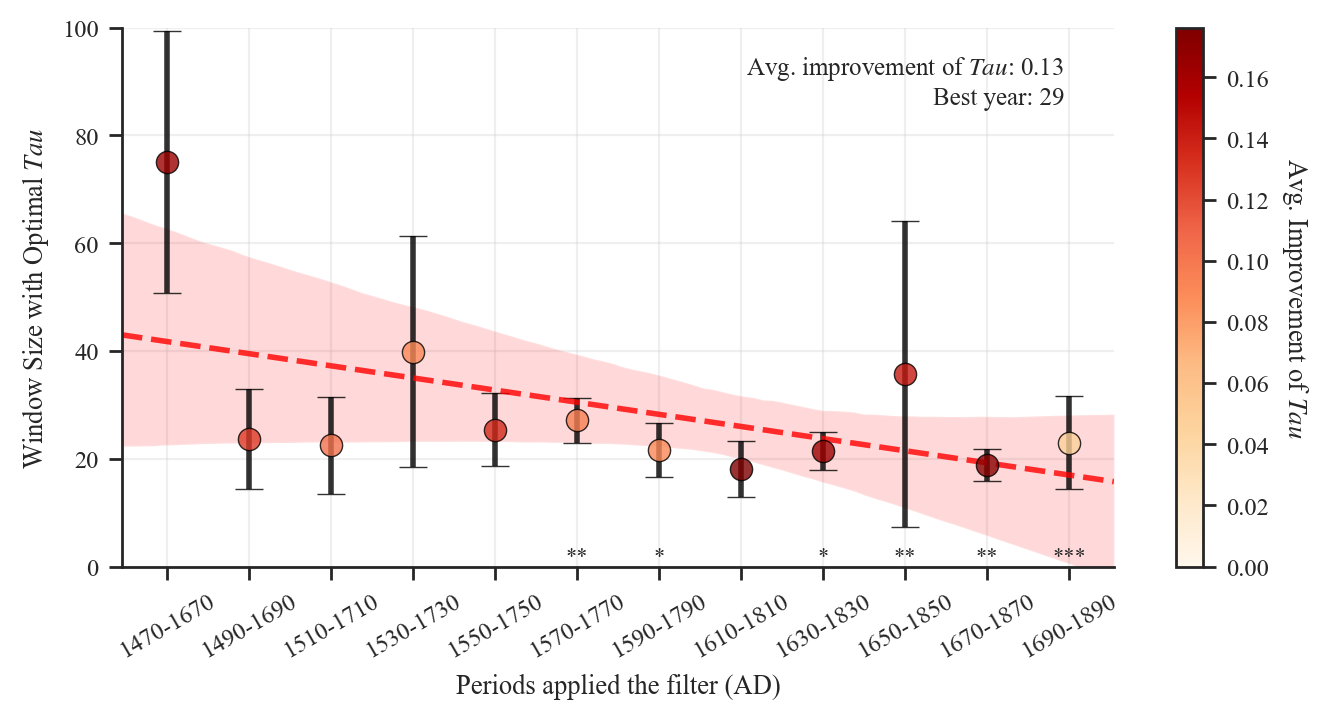

In [6]:
from shifting_baseline.compare import sweep_slices
from shifting_baseline.filters import calc_std_deviation
from shifting_baseline.compare import sweep_max_corr_year

import matplotlib.pyplot as plt
from shifting_baseline.utils.plot import plot_correlation_windows

slices, mid_year, slice_labels = sweep_slices(
    start_year=1470,
    window_size=200,
    step_size=20,
    end_year=END,
)

data1, data2 = history.merge_with(
    tree_ring,
    split=True,
)
max_corr_year, max_corr, r_benchmark_list, p_value_list = sweep_max_corr_year(
    data1=data1,
    data2=data2,
    slices=slices,
    corr_method=cfg.corr_method,
    windows=np.arange(2, 100),
    min_periods=np.repeat(cfg.min_period, 98),
    filter_func=calc_std_deviation,
    ratio=cfg.ratio,
)
# 计算最大相关性改进值
max_corr_improvment = np.zeros_like(max_corr)
for i, (corr, r_benchmark) in enumerate(zip(max_corr, r_benchmark_list)):
    max_corr_improvment[i] = corr - r_benchmark
    # if p_value_list[i] < 0.1:
    #     max_corr_improvment[i] = corr - r_benchmark
    # else:xw
    #     max_corr_improvment[i] = np.nan

# 使用函数
ax = plot_correlation_windows(
    max_corr_year,
    max_corr_improvment,
    mid_year,
    slice_labels,
    p_value_list=p_value_list,
)
lims = ax.get_xlim()
ax.set_xlim(lims)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
mean_improvement = np.nanmean(max_corr_improvment)
best_year = np.stack(max_corr_year).mean()
ax.text(
    0.95,
    0.95,
    f"Avg. improvement of $Tau$: {mean_improvement:.2f}\nBest year: {best_year:.0f}",
    ha="right",
    va="top",
    transform=ax.transAxes,
)
ax.set_ylim(0, 100)
plt.show();

In [7]:
r_benchmark_avg = np.mean(np.array(r_benchmark_list))
max_corr_avg = np.mean(np.stack(max_corr))
(max_corr_avg - r_benchmark_avg) / r_benchmark_avg

1.254792365014192

### 箱线图

In [8]:
from shifting_baseline.compare import compare_corr
from shifting_baseline.utils.calc import rand_generate_from_std_levels
from shifting_baseline.constants import STAGE1, END

temp_hist = HistoricalRecords(
    shp_path=cfg.ds.atlas.shp,
    data_path=cfg.ds.atlas.file,
    symmetrical_level=True,
    to_std=None,
)

ds_arr = rand_generate_from_std_levels(temp_hist.data, n_samples=100)
ds_arr = np.nanmean(ds_arr, axis=2)

window = 20


def get_sliding_corr(ds, window, min_period=None):
    if min_period is None:
        min_period = cfg.min_period
    rolling_kwargs = {
        "window": window,
        "min_periods": min_period,
    }

    filtered_corr_list = []
    benchmark_corr_list = []
    for i in range(ds.shape[0]):
        pred = pd.Series(ds[i, :], index=temp_hist.data.index).loc[STAGE1:END]
        true = pd.Series(tree_ring.loc[STAGE1:END])
        filtered_r, filtered_p, _ = compare_corr(
            classify(pred, handle_na="skip"),
            true,
            window_error="nan",
            filter_func=calc_std_deviation,
            filter_side=cfg.filter_side,
            corr_method=cfg.corr_method,
            n_diff_w=0,
            **rolling_kwargs,
        )
        benchmark_r, benchmark_p, _ = compare_corr(
            classify(pred, handle_na="skip"),
            true,
            corr_method=cfg.corr_method,
        )
        filtered_corr_list.append(filtered_r if filtered_p < 0.05 else np.nan)
        benchmark_corr_list.append(benchmark_r if benchmark_p < 0.05 else np.nan)

    df1 = pd.DataFrame(
        {
            "Kendall's Tau": filtered_corr_list,
            "Window": window,
            "Method": "Filtered",
        }
    )
    df2 = pd.DataFrame(
        {
            "Kendall's Tau": benchmark_corr_list,
            "Window": window,
            "Method": "Original",
        }
    )
    return pd.concat([df1, df2])


ds = pd.concat([get_sliding_corr(ds_arr, window) for window in cfg.violin_windows])
ds.head()

INFO | 处理为对称等级 ...


/var/folders/s9/w7bh_d6x1h915wcvpbp117tm0000gn/T/ipykernel_2877/3501215691.py:13: RuntimeWarning: Mean of empty slice
  ds_arr = np.nanmean(ds_arr, axis=2)


,Kendall's Tau,Window,Method
0,0.188539,20,Filtered
1,0.181267,20,Filtered
2,0.181878,20,Filtered
3,0.198844,20,Filtered
4,0.208552,20,Filtered


Text(0, 0.5, "Kendall's Tau")

3.3441824289680115e-254

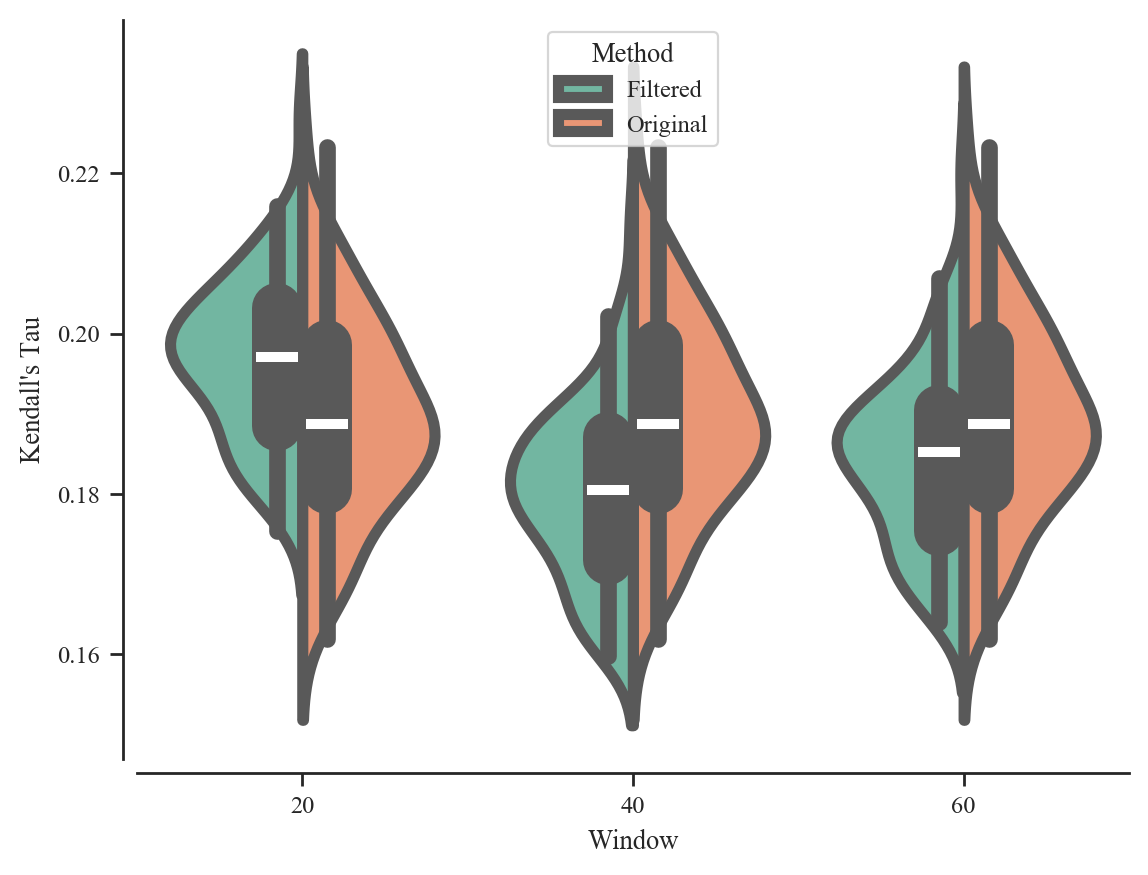

In [9]:
from scipy.stats import ttest_rel

ax = sns.violinplot(
    data=ds,
    hue="Method",
    x="Window",
    y="Kendall's Tau",
    palette="Set2",
    linewidth=4,
    split=True,
)
ax.set_ylabel("Kendall's Tau")
sns.despine(ax=ax, offset=5)
ttest = ttest_rel(ds.iloc[:, 0], ds.iloc[:, 1])
ttest.pvalue

<Axes: xlabel='Window', ylabel="Kendall's Tau">

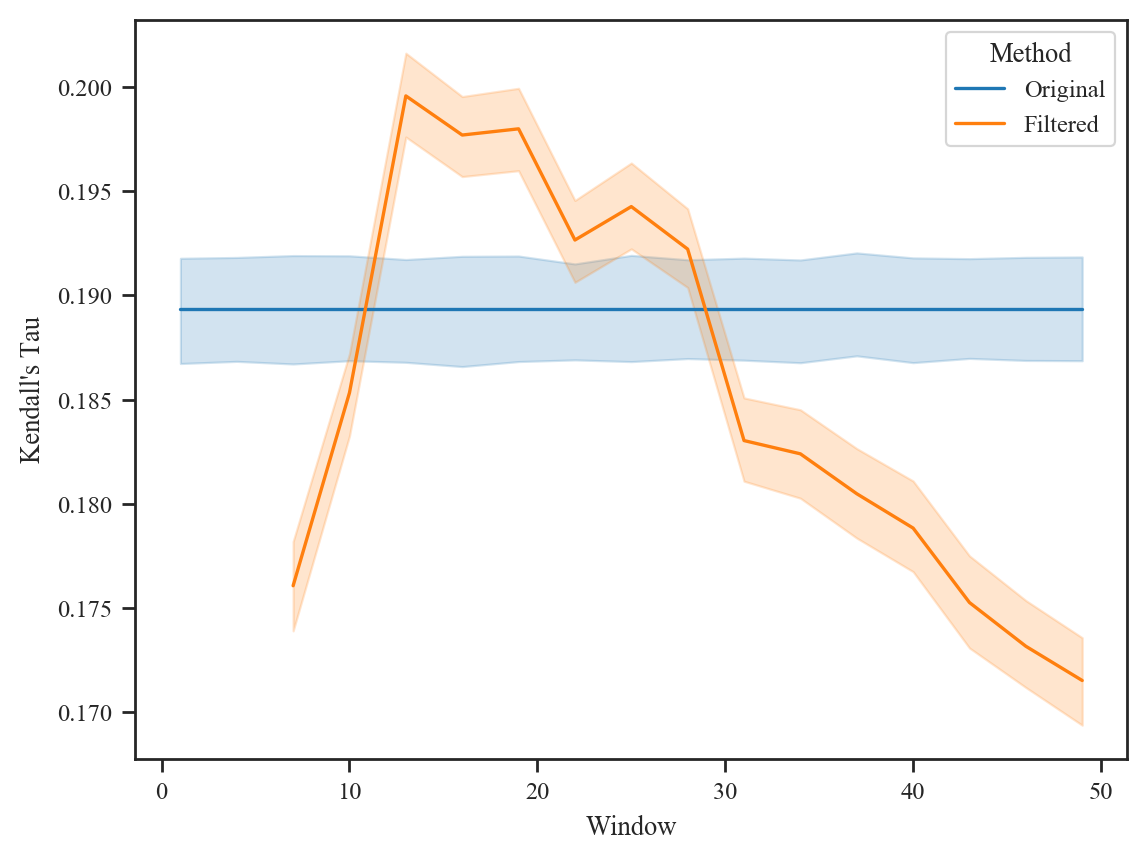

In [10]:
windows = np.arange(1, 50, 3)
ds = pd.concat([get_sliding_corr(ds_arr, window, min_period=5) for window in windows])

sns.lineplot(data=ds.dropna(), x="Window", y="Kendall's Tau", hue="Method")

### 综合作图

INFO | 开始计算相关性 kendall，时间切片: slice(1469, 1900, None)
INFO | 基准相关系数: 0.18500


INFO | 最大相关性系数: 0.19813，改进百分比: 7.10%
INFO | 最大相关性系数年份: 16.0


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/compare.py:226: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  log.info("最大相关性系数年份: %s", float(filtered_df.idxmax().max()))


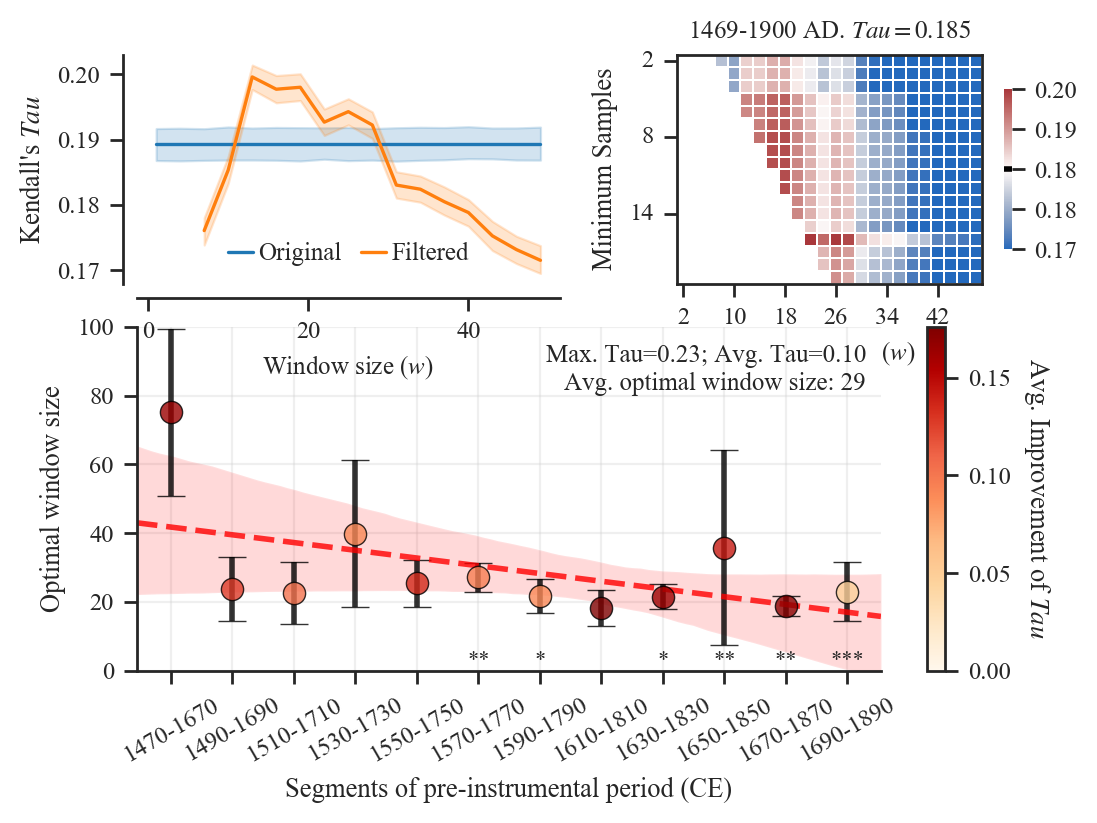

In [11]:
fig = plt.figure(figsize=(6, 4), constrained_layout=False)  # 增加高度

gs = fig.add_gridspec(
    ncols=2,
    nrows=2,
    height_ratios=[1, 1.5],
    hspace=0.15,
    # wspace=0.12,
)
ax1 = fig.add_subplot(gs[0, 1])

df, r_benchmark, ax1 = experiment_corr_2d(
    data1=data1,
    data2=data2,
    time_slice=slice_now,
    corr_method=cfg.corr_method,
    filter_func=calc_std_deviation,
    filter_side=cfg.filter_side,
    ax=ax1,
    n_diff_w=5,
    std_offset=0,
    max_window=50,
)
ax1.set_title(
    f"{slice_now.start}-{slice_now.stop} AD. $Tau={r_benchmark:.3f}$",
    fontsize=9,
)
ax1.locator_params(axis="x", nbins=9)  # x轴最多9个主刻度
ax1.locator_params(axis="y", nbins=4)  # y轴最多9个主刻度
ax1.tick_params(axis="both", rotation=0)
ax1.set_xlabel("Window size ($w$)", fontsize=9)

#### ================================================
ax3 = fig.add_subplot(gs[1, :])

# 绘制不同历史时期的窗口图
ax3 = plot_correlation_windows(
    max_corr_year,
    max_corr_improvment,
    mid_year,
    slice_labels,
    p_value_list=p_value_list,
    ax=ax3,
)
lims = ax3.get_xlim()
# ax3.axvspan(1636, 1720, color="gray", alpha=0.2, label="Dynasty Transition")

best_year = np.stack(max_corr_year).mean()
ax3.text(
    0.98,
    0.95,
    f"Max. Tau={max_corr_avg:.2f}; Avg. Tau={r_benchmark_avg:.2f}\nAvg. optimal window size: {best_year:.0f}",
    ha="right",
    va="top",
    transform=ax3.transAxes,
)
ax3.set_xlim(lims)
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.set_xlabel("Segments of pre-instrumental period (CE)")
ax3.set_ylabel("Optimal window size")
ax3.set_ylim(0, 100)

# 绘制小提琴图 ================================================
ax2 = fig.add_subplot(gs[0, 0])
# ax2 = sns.violinplot(
#     data=ds,
#     hue="Method",
#     x="Window",
#     y="Kendall's Tau",
#     palette="Set2",
#     linewidth=1.5,
#     split=True,
# )
# # ax2.text(0.01, 0.95, "$p<0.001$", ha="left", va="top", transform=ax2.transAxes)

sns.lineplot(data=ds.dropna(), x="Window", y="Kendall's Tau", hue="Method", ax=ax2)
ax2.legend(
    loc="best",
    # bbox_to_anchor=(1, 1.08),
    fontsize=9,
    ncol=2,
    title_fontsize=9,
    frameon=False,
    handlelength=1.0,  # length of the legend handles
    handletextpad=0.2,  # space between handle and text
    columnspacing=0.8,  # space between columns
    labelspacing=0.2,  # vertical space between rows
    borderpad=0.2,  # padding inside the legend box
)
ax2.set_ylabel("Kendall's $Tau$")
ax2.set_xlabel("Window size ($w$)", fontsize=9)
sns.despine(ax=ax2, offset=5)


# 综合作图 ================================================
fig.savefig(cfg.ds.fig4, dpi=300)
plt.show();